<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINN_method_for_1D_Burgers'_equation_inverse_problem_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import pandas as pd

from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git &> /dev/null
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions
import physicsInformedNeuralNetworks

from google.colab import drive
drive.mount('/content/gdrive')

## Finite difference solver

In [5]:
# solves 1D Burgers' equations using devito finite difference computation
def devitoSolver_1D_Burgers(tResolution, xResolution, tMin, tMax, xMin, xMax, l1, l2):
    # define discretisation
    # extent x direction
    extent_x = xMax - xMin
    # number of x grid points
    nx = xResolution
    # x direction step size
    dx = extent_x / (nx - 1)
    # time extent (total duration)
    T = tMax - tMin
    # time step
    dt = 1e-4
    # number of time points
    nt = int(T / dt)

    # create 1D grid and assign dimension variable names
    grid = Grid(shape=(nx), extent=(extent_x))
    x = grid.dimensions
    t = grid.stepping_dim
    # create time function on grid
    # space order of 2 to enable 2nd derivative
    u = TimeFunction(name='u', grid=grid, space_order=2)
    # create constant (viscosity)
    a = Constant(name='a')
    b = Constant(name='b')
    # define 1D Burgers' equation
    equation_u = Eq(u.dt + a*u*u.dxl, b*u.dx2)
    # create stencil by solving for next time step
    stencil_u = solve(equation_u, u.forward)
    # define equation for next time step
    update_u = Eq(u.forward, stencil_u)
    # define boundary conditions
    # u = 0 at min and max extent of x
    boundaryConditions = [Eq(u[t+1, 0], 0.)]
    boundaryConditions += [Eq(u[t+1, nx], 0.)]
    # define operator based on equation and boundary conditions
    op = Operator([update_u] + boundaryConditions)

    # set solution space to 0s
    u.data[:] = 0
    # create a dummy x array from -1 to +1
    dummyX = np.arange(-1, 1+dx, dx)
    # set initial conditions using dummy x array
    u.data[0] = -1 * np.sin(np.pi * dummyX)

    # define number of time steps to compute before storing result
    batchSize = int(nt/tResolution)

    # initialise empty array to store computed solution
    results = np.zeros((nx, tResolution))
    # store initial conditions in results array
    results[:,0] = u.data[0].copy()

    # log start time to measure performance
    startTime = perf_counter()

    # iterate over result steps
    # start from 1 not 0 as results at step 0 are the initial conditions
    for timeStep in range(1, tResolution):
        # compute solution after batchSize time steps
        summary = op.apply(time=batchSize, dt=dt, a=l1, b=l2)
        # store computed solution in results array
        results[:,timeStep] = u.data[0].copy()

    # record computation time
    duration = perf_counter()-startTime

    return results, duration

## Data generator

In [6]:
def dataGenerator_1D_BurgersInverse(FD_solution, N):

    trainingArray = np.zeros((N, 3))
    tIdxArray = rng.choice(FD_solution.shape[1], size=N)
    xIdxArray = rng.choice(FD_solution.shape[0], size=N)

    trainingArray[:,0] = tIdxArray / FD_solution.shape[1]
    trainingArray[:,1] = ((xIdxArray / FD_solution.shape[0]) * 2) - 1.
    trainingArray[:,2] = FD_solution[xIdxArray, tIdxArray]

    return trainingArray

In [7]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

l1 = 1.
l2 = 0.01/np.pi

FD_solution, FD_duration = devitoSolver_1D_Burgers(1000, 1000, tMin, tMax, xMin, xMax, l1, l2)

N = 2000

NArray = dataGenerator_1D_BurgersInverse(FD_solution, N)

Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s
Operator `Ke

## Define PINN

In [20]:
inverseResults=pd.read_csv('/content/gdrive/My Drive/1dBurgers_inv_results.csv', index_col=0)

testNumber = inverseResults.shape[0]+1

testNumber

1

In [9]:
# define network characteristics
hiddenLayers = 7
nodesPerLayer = 20
activationFunction = nn.Tanh()
maxIterations = 50000
maxEvaluations = 50000
l1_init = 0.
l2_init = -6.
inverseProblem = True

# create network and print number of trainable parameters
model = physicsInformedNeuralNetworks.PINN_1D_Burgers(hiddenLayers, nodesPerLayer, activationFunction, maxIterations, maxEvaluations, l1_init, l2_init, inverseProblem)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

Network parameters: 3023


In [11]:
# N = 2000

# NArray = dataGenerator_1D_BurgersInverse(FD_solution, N)

noise = rng.normal(0, 1, NArray.shape[0]) * NArray[:,-1].max() * 0.1

# NArray[:,-1] = NArray[:,-1] + noise

## Perform training

In [12]:
# train model
model.trainer(NArray, NArray[:,:-1])

Epoch: 1 --- Elapsed time: 0.31s --- Loss: 0.3845154047012329
Epoch: 2 --- Elapsed time: 0.43s --- Loss: 0.37091630697250366
Epoch: 4 --- Elapsed time: 0.68s --- Loss: 0.3699905276298523
Epoch: 8 --- Elapsed time: 0.92s --- Loss: 0.23229087889194489
Epoch: 16 --- Elapsed time: 1.11s --- Loss: 0.20487746596336365
Epoch: 32 --- Elapsed time: 1.52s --- Loss: 0.10178584605455399
Epoch: 64 --- Elapsed time: 2.39s --- Loss: 0.0387166365981102
Epoch: 128 --- Elapsed time: 4.86s --- Loss: 0.02584843337535858
Epoch: 256 --- Elapsed time: 8.07s --- Loss: 0.015861138701438904
Epoch: 500 --- Elapsed time: 14.12s --- Loss: 0.0093860924243927
Epoch: 1000 --- Elapsed time: 26.65s --- Loss: 0.002785690128803253
Epoch: 1500 --- Elapsed time: 39.14s --- Loss: 0.0009629562264308333
Epoch: 2000 --- Elapsed time: 51.63s --- Loss: 0.00047137431101873517
Epoch: 2500 --- Elapsed time: 65.19s --- Loss: 0.00029257763526402414
Epoch: 3000 --- Elapsed time: 77.77s --- Loss: 0.00020307213708292693
Epoch: 3500 --- 

In [18]:
model.history[-1,0]

6.523456977447495e-05

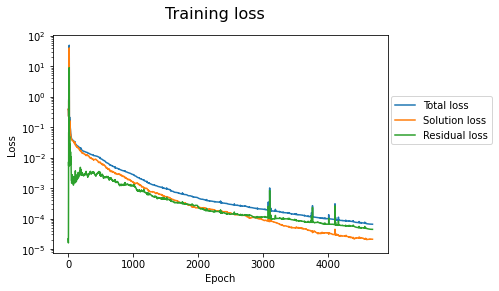

In [13]:
# plot training loss curves
utilityFunctions.trainingHistoryPlot(model.history, ['Total loss', 'Solution loss', 'Residual loss'], 'Loss', 'Training loss', yLogAx=True)
plt.show()

In [16]:
print(f'l1 true: {l1}')
print(f'l2 true: {l2}')

l1Pred = model.lxHistory[-1,0]
l2Pred = model.lxHistory[-1,1]

l1Err = 100 * abs(l1Pred - l1) / l1
l2Err = 100 * abs(l2Pred - l2) / l2

print(f'l1 predicted: {l1Pred}')
print(f'l2 predicted: {l2Pred}')

print(f'l1 % error: {l1Err:.2f}%')
print(f'l2 % error: {l2Err:.2f}%')


l1 true: 1.0
l2 true: 0.003183098861837907
l1 predicted: 0.9943181276321411
l2 predicted: 0.003312476444989443
l1 % error: 0.57%
l2 % error: 4.06%


l1 true: 1.0
l2 true: 0.003183098861837907
l1 predicted: 0.9943181276321411
l2 predicted: 0.003312476444989443
l1 % error: 0.57%
l2 % error: 4.06%


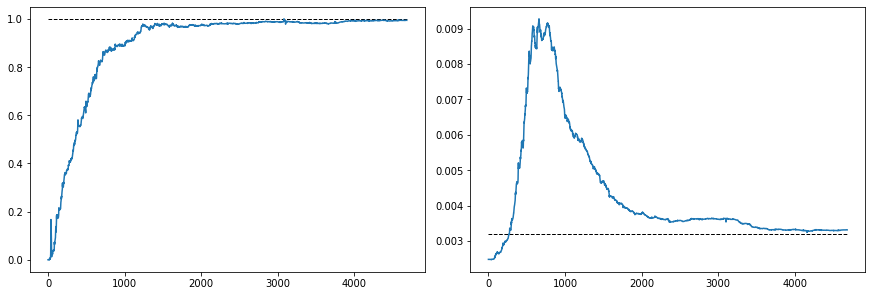

In [14]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 4),
    constrained_layout=True
    )
gs = GridSpec(1, 4, figure=fig)

# add solution plot
l1Ax = fig.add_subplot(gs[:,:2])
l1Ax.plot(model.lxHistory[:,0])
l1Ax.hlines(y=l1, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1)
# l1Ax.set_yscale('log')

l2Ax = fig.add_subplot(gs[:,2:])
l2Ax.plot(model.lxHistory[:,1])
l2Ax.hlines(y=l2, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1) 
# l2Ax.set_yscale('log')

plt.show()

## Generate solution

In [21]:
# compute meshgrid, solution and residual
# arguments: (model, xDim, yDim, xMin, xMax, yMin, yMax, xArg, yArg, residual=True)
mesh_x, mesh_y, PINN_solution, PINN_residual = utilityFunctions.create2dMeshData_1dBurgers(model, 1000, 1000, 0, 1, -1, 1, 't', 'x', residual=True)

relativeErr2 = np.linalg.norm(FD_solution-PINN_solution, 2) / np.linalg.norm(FD_solution, 2)

## Results

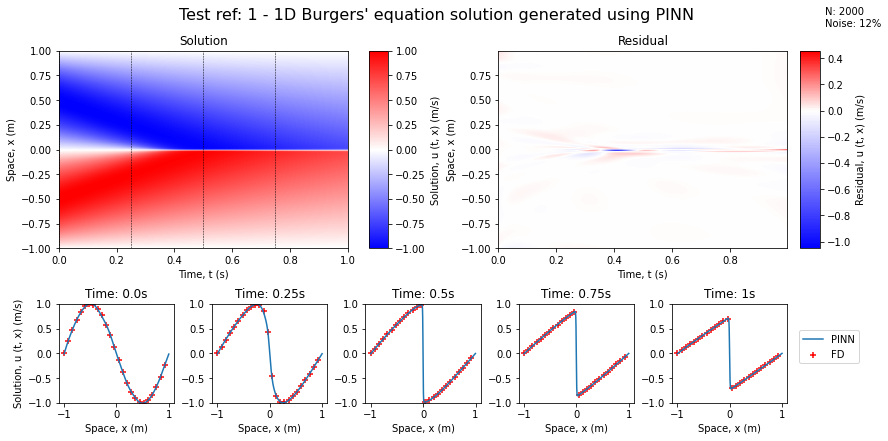

In [40]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(mesh_x, mesh_y, PINN_solution, cmap='bwr', vmin=-1, vmax=1)
solutionAx.set_xlim([0, 1])
solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
norm = TwoSlopeNorm(vcenter=0)
residualPlot = residualAx.pcolormesh(mesh_x, mesh_y, PINN_residual, cmap='bwr', norm=norm)
residualAx.set_title('Residual')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

markEvery = np.arange(0, FD_solution.shape[1], 40)

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(mesh_y[:, i*(mesh_y.shape[1]//4)], PINN_solution[:, i*(mesh_y.shape[1]//4)])

        tPlot.scatter(mesh_y[:, i*(mesh_y.shape[1]//4)][markEvery], FD_solution[:, i*(mesh_y.shape[1]//4)][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      )

        tPlot.set_title('Time: ' + str(i*mesh_x[0, mesh_x[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*mesh_x[0, mesh_x[0].shape[0]//4], ymin=mesh_y[0,0], ymax=mesh_y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(mesh_y[:, -1], PINN_solution[:, -1],
                   label='PINN',
                   )

        tPlot.scatter(mesh_y[:, -1][markEvery], FD_solution[:, -1][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      label='FD',
                      )
        
        tPlot.legend(loc=[1.1, 0.4])

        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

fig.text(0.95, 0.95, f'N: {N}\nNoise: {12}%')
# figure title
fig.suptitle(f"Test ref: {testNumber} - 1D Burgers' equation solution generated using PINN", fontsize=16)

# fig.savefig(f"Test ref: {testNumber} - 1D Burgers' solution - PINN", bbox_inches='tight')
plt.show()

In [ ]:
inverseResults = inverseResults.append({
    'Test ref': testNumber,
    'N': ,
    'Noise %',
    'Terminating loss': model.history[-1,0],
    'Solution error': relativeErr2,
    'L1 error %',
    'L2 error %',
    },
    ignore_index=True)

inverseResults.to_csv('/content/gdrive/My Drive/1dBurgers_inv_results.csv')

## Extra

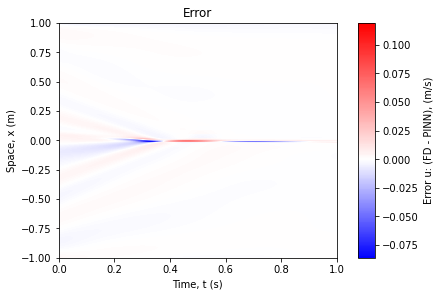

In [ ]:
fig = plt.figure(
    figsize=(6, 4),
    constrained_layout=True
    )
gs = GridSpec(1, 1, figure=fig)
norm = TwoSlopeNorm(vcenter=0)

errorAx = fig.add_subplot(gs[:,:])
errorPlot = errorAx.pcolormesh(mesh_x, mesh_y, FD_solution - PINN_solution, cmap='bwr', norm=norm)

errorAx.set_xlim([0, 1])
errorAx.set_ylim([-1, 1])

errorAx.set_title('Error')
errorAx.set_xlabel('Time, t (s)')
errorAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(errorPlot, use_gridspec=True)
cbar.set_label('Error u: (FD - PINN), (m/s)')

In [ ]:
fig, ax  = plt.subplots(figsize=(6, 4), constrained_layout=True)

sns.scatterplot(
    ax=ax,
    x=NArray[:,0],
    y=NArray[:,1],
    hue=NArray[:,2],
    palette='bwr',
)
# s=5.,
# c='k',
# marker='.',

ax.set_title('Training points distribution')
ax.set_xlabel('Time, t (s)')
ax.set_ylabel('Space, x (m)')
plt.show()

In [ ]:
# inverseResults = pd.DataFrame(columns=[
#     'Test ref',
#     'N',
#     'Noise %',
#     'Terminating loss',
#     'Solution error',
#     'L1 error %',
#     'L2 error %',
#     ])

# inverseResults.to_csv('/content/gdrive/My Drive/1dBurgers_inv_results.csv')